# Setting configure

In [1]:
# !pip install geopandas
# !pip install plotly-express
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import missingno as msno
import folium
import plotly.express as px

In [2]:
class Config:
  month_range = (2,9)
  start, end = month_range
  json_path_months = ['/content/drive/MyDrive/Colab Notebooks/CS506 project/database/postalcode/postal_code'+str(i)+'.json' for i in range(start, end+1)]
  MA_zip_list_path = '/content/drive/MyDrive/Colab Notebooks/CS506 project/database/usa_zipcode_of_ma.csv'
  MA_zip_geo_url = 'https://raw.githubusercontent.com/lijunwei19/State-zip-code-GeoJSON/master/ma_massachusetts_zip_codes_geo.min.json'

# Reading visitors flow data 

In [3]:
# list in visitors flow in month order
json_list = []
config = Config()
for filename in config.json_path_months:
  f= open(filename)
  json_list.append(json.load(f))

In [4]:
import requests
Geo_Json = requests.get(config.MA_zip_geo_url).json()
# Geo_Json['features'][1]['properties']['ZCTA5CE10']
# Geo_Json['features'][0]['geometry']['coordinates']

df_ma_zip = pd.read_csv(config.MA_zip_list_path, usecols=['zip','City', 'State', 'County Name' ])
df_ma_zip['zip'] =  ['0'+ str(i)  for i in df_ma_zip['zip']]
df_ma = df_ma_zip[['zip','City', 'State', 'County Name' ]]
df_ma_zip = df_ma.to_numpy()
df_ma.head()

zip      City State County Name
0  02351  ABINGTON    MA    PLYMOUTH
1  02018    ACCORD    MA    PLYMOUTH
2  01720     ACTON    MA   MIDDLESEX
3  02743  ACUSHNET    MA     BRISTOL
4  01220     ADAMS    MA   BERKSHIRE

In [5]:
fname = '/content/drive/MyDrive/Colab Notebooks/CS506 project/ma_massachusetts_zip_codes_geo.min.json'
G = gpd.read_file(fname)
Geo =G.to_numpy()
nil=G[['ZCTA5CE10','geometry']]

nil.head()

ZCTA5CE10                                           geometry
0     02536  POLYGON ((-70.59239 41.56006, -70.59268 41.559...
1     02556  POLYGON ((-70.62389 41.61673, -70.62633 41.617...
2     02540  POLYGON ((-70.62389 41.61673, -70.62262 41.616...
3     02646  POLYGON ((-70.07925 41.67769, -70.07864 41.677...
4     01237  POLYGON ((-73.23558 42.49333, -73.23587 42.493...

# Building visitors flow CSV dataset

In [6]:
data = []
for i, month_dic in enumerate(json_list):
  for zip, value in month_dic.items():
    for day, people in value.items():
      # year, month, day, zips, County Name , people
      row =[]
      a = '0'+zip
      row.append('2020')
      row.append(str(i+2))
      row.append(day)
      row.append(a)
      row.append(people)
      idx = np.argwhere(df_ma_zip==a)
      if idx.any():
        row.append(df_ma_zip[idx[0][0],1])
        row.append(df_ma_zip[idx[0][0],2])
        row.append(df_ma_zip[idx[0][0],3])
      for c ,z in enumerate(Geo[:,1]):
        if z == a:
          row.append(Geo[c,11])
          break
      data.append(row)
df = pd.DataFrame(data, columns=['Year','Month','Week', 'ZCTA5CE10', 'People','City', 'State', 'County Name', 'geometry'])
df.head()


Year Month  ... County Name                                           geometry
0  2020     2  ...     SUFFOLK  POLYGON ((-71.14485999999999 42.247463, -71.14...
1  2020     2  ...     SUFFOLK  POLYGON ((-71.14485999999999 42.247463, -71.14...
2  2020     2  ...     SUFFOLK  POLYGON ((-71.14485999999999 42.247463, -71.14...
3  2020     2  ...     SUFFOLK  POLYGON ((-71.14485999999999 42.247463, -71.14...
4  2020     2  ...     SUFFOLK  POLYGON ((-71.14485999999999 42.247463, -71.14...

[5 rows x 9 columns]

AxesSubplot(0.125,0.125;0.698618x0.755)


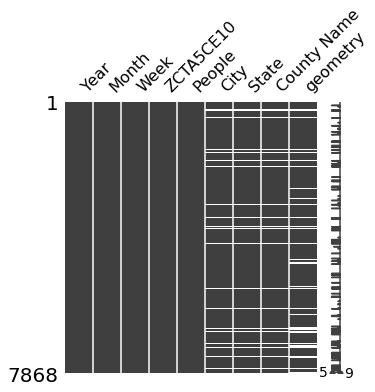

In [7]:
print(msno.matrix(df, figsize=(5,5)))
df.dropna(inplace=True)

# Data Visualization

In [9]:
def draw_map(df, month, week):
  df_2_M = df.loc[(df['Month']==str(month)) & (df['Week']==week),['ZCTA5CE10','People','County Name','City','State']]
  nilpop = nil.merge(df_2_M, on='ZCTA5CE10')
  x_map=nilpop.centroid.x.mean()
  y_map=nilpop.centroid.y.mean()
  # print(x_map,y_map)
  mymap = folium.Map(location=[y_map, x_map], zoom_start=9,tiles=None)
  folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)

  myscale = (nilpop['People'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()


  mymap.choropleth(
  geo_data=nilpop,
  name='Choropleth',
  data=nilpop,
  columns=['ZCTA5CE10','People'],
  key_on="feature.properties.ZCTA5CE10",
  fill_color='YlOrRd',
  threshold_scale=myscale,
  fill_opacity=0.65,
  line_opacity=0.2,
  legend_name='Safegraph dataset -- Vistors flow in 2020/0'+str(month)+'/'+week,
  smooth_factor=0
  )


  style_function = lambda x: {'fillColor': '#ffffff', 
                              'color':'#000000', 
                              'fillOpacity': 0.1, 
                              'weight': 0.1}
  highlight_function = lambda x: {'fillColor': '#000000', 
                                  'color':'#000000', 
                                  'fillOpacity': 0.50, 
                                  'weight': 0.1}
  NIL = folium.features.GeoJson(
      nilpop,
      style_function=style_function, 
      control=False,
      highlight_function=highlight_function, 
      tooltip=folium.features.GeoJsonTooltip(
          fields=['State','City','ZCTA5CE10','County Name','People'],
          aliases=['State: ','City: ','Zip: ','County Name: ','Vistor flows from Safegraph database'+'2020/'+str(month)+'/'+week+' :'],
          style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
      )
  )
  mymap.add_child(NIL)
  mymap.keep_in_front(NIL)
  folium.LayerControl().add_to(mymap)
  return mymap
draw_map(df, 2, 'Sunday')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.



In [10]:
df_M = df.query("Week == 'Monday'") # remove Asia for visibility

fig = px.line(df_M, x="Month", y="People", color="ZCTA5CE10",
              line_group="ZCTA5CE10", hover_name="ZCTA5CE10", title='2020/09 - 2020/09 Every Monday Visitors Flow in Boston Area')
fig.show()

In [11]:
fig = px.bar(df, x="Week", y="People", color="ZCTA5CE10", 
             facet_col="Month",
             category_orders={"Month":['2','3','4','5','6','7','8','9']})
fig.show()

In [12]:
fig = px.line(df, x="Month", y="People", color="ZCTA5CE10", 
             facet_col="Week",
             category_orders={"Week":['Monday','Tuesday','Wednesday','Thursday', 'Friday']})
fig.show()